# **Expectation-Maximization algorithm** (hidden model)
### Author: Martí Cortada Garcia
---

In [8]:
# Import required libraries
import numpy as np
from Bio import SeqIO, Phylo
from io import StringIO
from collections import Counter, OrderedDict
import itertools
import pandas as pd
import math
import copy

# Import required functions from modules we have programmed
from data_simulation import simulate

### **Input:**
We have a tree $T$ (where the root corresponds to the internal node codified as `Int_0`) and the alignments of the leaves.

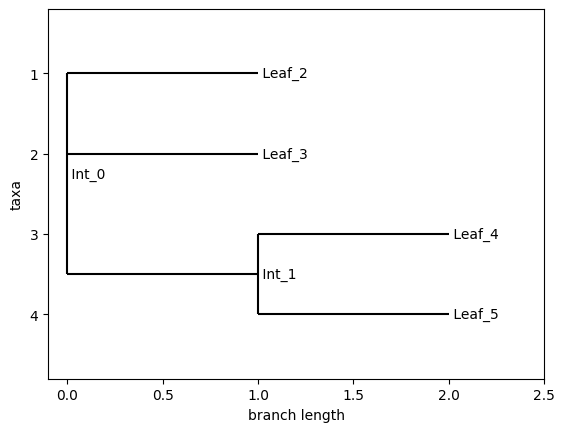

In [10]:
newick_tree = open("./newick.txt", "r")
newick = newick_tree.read()
newick_tree.close()
tree = Phylo.read(StringIO(newick), "newick")

# Change nodes names
for idx, clade in enumerate(tree.get_nonterminals()):
    clade.name = "Int_" + str(idx) if idx > 0 else "Int_0" 

# Change leaves names
for idx, clade in enumerate(tree.get_terminals()):
    clade.name = "Leaf_" + clade.name 

Phylo.draw(tree)

net = Phylo.to_networkx(tree) # to graph

In [9]:
edges, node_distr, filename = simulate(net, 500) # simulate data calling the module data_simulation.py 

# Preprocess leave alignments
leave_alignments = [i for i in SeqIO.parse(filename, "fasta")]
for i in leave_alignments:
    print("Seq>", i.seq)
# Codify the alphabet {A,G,C,T} -> {0,1,2,3}
leave_sequences = []
for i in leave_alignments:
    seq = ""
    for j in i.seq:
        if j == "A":
            seq += "0"
        elif j == "G":
            seq += "1"
        elif j == "C":
            seq += "2"
        elif j == "T":
            seq += "3"
        else:
            raise ValueError("Invalid nucleotide")
    leave_sequences.append(seq)
#leave_sequences
edges

TypeError: simulate() missing 1 required positional argument: 'directory'

---
## **EM algorithm**

In [12]:
from evaluate import init_EM

Results = init_EM(newick, 1000)

In [13]:
for i in range(len(Results)):
    print("Source:", Results[i].source)
    print("Target:", Results[i].target)
    print("Matrix:\n", Results[i].matrix)

Source: Int_0
Target: Leaf_2
Matrix:
 [[0.80529814 0.06095358 0.09251042 0.04123786]
 [0.05611119 0.71483627 0.11102639 0.11802615]
 [0.0952762  0.07415636 0.731184   0.09938344]
 [0.02196288 0.0820518  0.08234946 0.81363586]]
Source: Int_0
Target: Leaf_3
Matrix:
 [[0.63632807 0.06782976 0.1446222  0.15121997]
 [0.12810897 0.67208297 0.04706075 0.15274731]
 [0.10204507 0.09021686 0.74449869 0.06323937]
 [0.06570111 0.08178298 0.05155947 0.80095644]]
Source: Int_0
Target: Int_1
Matrix:
 [[0.72577892 0.07421689 0.0831795  0.11682468]
 [0.08700214 0.7261134  0.06686419 0.12002027]
 [0.09519544 0.182137   0.68012648 0.04254107]
 [0.06761601 0.06509887 0.08961157 0.77767356]]
Source: Int_1
Target: Leaf_4
Matrix:
 [[0.85639817 0.07234946 0.04036045 0.03089192]
 [0.0298384  0.73128255 0.0944944  0.14438465]
 [0.03533407 0.10420379 0.77836777 0.08209437]
 [0.06403097 0.03195277 0.06966545 0.8343508 ]]
Source: Int_1
Target: Leaf_5
Matrix:
 [[0.80075352 0.06438893 0.11198018 0.02287738]
 [0.0740

In [14]:
# Auxiliary functions

def init_root_distribution():
    """
    Initialise estimation for the root distribution (all probabilities between 0.2 and 0.3)
    """
    estimated_root_distribution = []
    while True:
        estimated_root_distribution = np.random.dirichlet([1,1,1,1])
        i = 0
        while i<4:
            if estimated_root_distribution[i] > 0.2 and estimated_root_distribution[i] < 0.3:
                i += 1
            else:
                break
        if i == 4:
            assert(np.sum(estimated_root_distribution) < 1.0000001 and np.sum(estimated_root_distribution) > 0.9999999)
            assert(estimated_root_distribution[i] > 0.2 and estimated_root_distribution[i] < 0.3 for i in range(4))
            break
    return estimated_root_distribution

def init_transition_matrix():
    """
    Initialise estimation for the transition matrices (which we estimate as LARGE-DIAGONAL-VALUE matrices)
    """
    M = np.zeros((4,4))
    i=0
    while i<4:
        R = np.random.dirichlet([1,1,1,1])
        if R[i] > 0.6 and R[i] < 0.8:
            M[i,:] = R 
            i = i + 1
    assert (M[i,i] > 0.6 and M[i,i] < 0.8 for i in range(4))
    assert (np.sum(M[i,:]) < 1.0000001 and np.sum(M[i,:]) > 0.9999999 for i in range(4))
    return M

def log_likelihood(states, u_i, params, root_distribution, n_int):
    """Compute the log-likehood of the tree"""
    logL = 0
    for obs in states:
        p_i = 0 
        observed_data = obs[n_int:]
        if observed_data in u_i:
            for state in states:
                if state[n_int:] == observed_data:
                    pi = root_distribution[int(state[0])]
                    for p in params.items():
                        u, v = int(p[1].edge[0].name.split("_")[1]), int(p[1].edge[1].name.split("_")[1])
                        pi *= p[1].transition_matrix[int(state[u]), int(state[v])]
                    p_i += pi
        logL += (u_i[observed_data] * math.log(p_i))
    return logL

############################################################################################################
########################################## FELSENSTEIN ALGORITHM ###########################################
############################################################################################################
# # Felsentstein algorithm
# # "((4,5),(2,3))"
# newick_tree = "(((4:1,5:1):1,(6:1,7:1):1):1,(8:1,9:1):1);"
# L_tree = Phylo.read(StringIO(newick_tree), "newick")
# # Change nodes names
# for idx, clade in enumerate(L_tree.get_nonterminals()):
#     id = 0
#     if idx == 2:
#         clade.name = "Int_Id_" + str(id)
#         id += 1
#     else:
#         clade.name = "Int_" + str(idx) if idx > 0 else "Int_0" 
# # Change leaves names
# for idx, clade in enumerate(L_tree.get_terminals()):
#     clade.name = "Leaf_" + clade.name 
# L_net = Phylo.to_networkx(L_tree) # to graph
# L_edges = []
# for edge in L_net.edges():
#     if edge[0].name.split("_")[1] == "Id" and edge[1].name.split("_")[1] == "Id":
#         u = str(edge[0].name.split("_")[1]) + "_" + str(edge[0].name.split("_")[2])
#         v = str(edge[1].name.split("_")[1]) + "_" + str(edge[1].name.split("_")[2])
#     elif edge[0].name.split("_")[1] == "Id" and edge[1].name.split("_")[1] != "Id":
#         u = str(edge[0].name.split("_")[1]) + "_" + str(edge[0].name.split("_")[2])
#         v = str(edge[1].name.split("_")[1])
#     elif edge[0].name.split("_")[1] != "Id" and edge[1].name.split("_")[1] == "Id":
#         u = str(edge[0].name.split("_")[1])
#         v = str(edge[1].name.split("_")[1]) + "_" + str(edge[1].name.split("_")[2])
#     else:
#         u = str(edge[0].name.split("_")[1])
#         v = str(edge[1].name.split("_")[1])
#     L_edges.append((u,v))
# # Create a dictionary to store the father and son information
# family_tree = {}
# # Loop through the edges and update the dictionary
# for father, son in L_edges:
#     if father not in family_tree:
#         family_tree[father] = []
#     family_tree[father].append(son)
# # Create a DataFrame from the dictionary
# tree_df = pd.DataFrame.from_dict(family_tree, orient='index')
# # Fill NaN values with empty strings
# tree_df = tree_df.fillna('')
# # Change column names
# tree_df.columns = ['child_1', 'child_2']

# class TreeInference():
#     def __init__(self, tree_data, leaf_values, params, root_distr):
#         # Set parameters
#         self.tree_data = tree_data.copy()
#         self.leaf_values = leaf_values
#         self.params = params
#         self.root_distr = root_distr

#         # Find IDs of internal nodes, all nodes and leaf nodes
#         self.internal_node_ids = np.array(tree_data.index)
#         self.all_node_ids = np.unique(np.concatenate((np.array(self.tree_data.index),
#                                                       np.array(self.tree_data["child_1"]),
#                                                       np.array(self.tree_data["child_2"]))))
#         self.leaf_node_ids = list(set(self.all_node_ids) - set(self.internal_node_ids))
        
#         # Count internal nodes and leaves for each row in tree_data and set root node
#         self.treeNodeCounts()
#         self.root_node = 0
        
#         # Get indexes for matricies for states, e.g. A is row 0, G is row 2...
#         states = ["A", "G", "C", "T"]
#         self.matrix_idx = dict(zip(states, range(len(states))))
        
#         # Empty matrix of likelihood for each node
#         self.L = np.full((len(self.all_node_ids), len(self.matrix_idx)), None)
#         # Log likelihood of whole tree
#         self.L_root = None
        

#     """
#     Calculates the number of internal nodes and leaves below each internal node.
#     This works by recursively iterating down the child nodes from the original internal node until a
#     leaf node is found, and then returning upwards counting the leaves and nodes.
#     The new derived information is then added as two new columns at the end of the data.
#     """
#     def treeNodeCounts(self):
#         n_nodes = np.array([])
#         n_leaves = np.array([])

#         # Set the number of internal nodes and leaves for each internal node row
#         for n in self.internal_node_ids:
#             num_nodes, num_leaves = self.checkNode(self.tree_data, n, self.internal_node_ids)
#             n_nodes = np.append(n_nodes, num_nodes)
#             n_leaves = np.append(n_leaves, num_leaves)

#         # Add new information to dataframe
#         self.tree_data["N_Internal"] = n_nodes
#         self.tree_data["N_Leaves"] = n_leaves
                
#     # Recursively find the number of internal nodes and leaves given a node ID
#     def checkNode(self, tree_data, node_id, node_array):
#         # Record the number of internal nodes and leaves below
#         num_nodes = 0
#         num_leaves = 0

#         # Find the left and right daughter nodes
#         child_1 = self.tree_data.loc[node_id]["child_1"]
#         child_2 = self.tree_data.loc[node_id]["child_2"]

#         # Check if found an internal node to the left
#         if child_1 in node_array:
#             # Recursively check nodes below
#             d1_nodes, d1_leaves = self.checkNode(self.tree_data, child_1, node_array)
#             num_nodes += d1_nodes + 1
#             num_leaves += d1_leaves

#         # Check if found an internal node to the right
#         if child_2 in node_array:
#             d2_nodes, d2_leaves = self.checkNode(self.tree_data, child_2, node_array)
#             num_nodes += d2_nodes + 1
#             num_leaves += d2_leaves

#         return num_nodes, num_leaves
    
    
#     # Calculate likelihood for an internal node
#     def nodeLikelihood(self, node_n, params):
#         # Find the left and right daughter nodes
#         child_1 = self.tree_data.loc[str(node_n)]["child_1"]
#         child_2 = self.tree_data.loc[str(node_n)]["child_2"]
        
#         # Check if likelihood of left child node set
#         if child_1 == "Id_0":
#             if (self.L[-1, 0] is None):
#                 # If not set then calculate child likelihood first
#                 self.nodeLikelihood(child_1, params)
#         else:
#             if (self.L[int(child_1), 0] is None):
#                 # If not set then calculate child likelihood first
#                 self.nodeLikelihood(int(child_1), params)
#         # Check if likelihood of right child node set
#         if child_2 == "Id_0":
#             if (self.L[-1, 0] is None):
#                 self.nodeLikelihood(child_2, params)
#         else:
#             if (self.L[int(child_2), 0] is None):
#                 self.nodeLikelihood(int(child_2), params)
        
#         M1, M2 = np.full((4,4),None), np.full((4,4),None)
#         if node_n == "Id_0":
#             # Create transition matrix for left and right child nodes
#             matrix_name_child1 = "M_0_to_" + str(child_1)
#             matrix_name_child2 = "M_0_to_" + str(child_2)
#             M1 = self.params[matrix_name_child1].transition_matrix
#             M2 = self.params[matrix_name_child2].transition_matrix
#         elif child_1 == "Id_0":
#             matrix_name_child2 = "M_" + str(node_n) + "_to_" + str(child_2)
#             M1 = np.identity(4)
#             M2 = self.params[matrix_name_child2].transition_matrix
#         elif child_2 == "Id_0":
#             matrix_name_child1 = "M_" + str(node_n) + "_to_" + str(child_1)
#             M1 = self.params[matrix_name_child1].transition_matrix
#             M2 = np.identity(4)
#         else:
#             matrix_name_child1 = "M_" + str(node_n) + "_to_" + str(child_1)
#             matrix_name_child2 = "M_" + str(node_n) + "_to_" + str(child_2)
#             M1 = self.params[matrix_name_child1].transition_matrix
#             M2 = self.params[matrix_name_child2].transition_matrix

#         # Get conditional likelihood of child nodes
#         if child_1 == "Id_0":
#             d1_likelihood = self.L[-1]
#         else:
#             d1_likelihood = self.L[int(child_1)]
#         if child_2 == "Id_0":
#             d2_likelihood = self.L[-1]
#         else:
#             d2_likelihood = self.L[int(child_2)]
        
#         # Calculate the likelihood of each state for the node
#         left_prob = np.sum(M1 * d1_likelihood, axis = 1)
#         right_prob = np.sum(M2 * d2_likelihood, axis = 1)
#         if node_n == "Id_0":
#             self.L[-1,:] = np.multiply(left_prob, right_prob)
#         else:
#             self.L[int(node_n),:] = np.multiply(left_prob, right_prob)
    
#     # Run Felsenstein’s algorithm to calculate the log likelihood of the tree
#     def calculateLikelihood(self, params, Estep):
#         # Clear matrix of likelihood for each node
#         self.L = np.full((len(self.all_node_ids), len(self.matrix_idx)), None)
        
#         # Set likelihood of leaf states
#         for leaf_n in self.leaf_node_ids:
#             if leaf_n == "Id_0":
#                 # Zero for non-matching base
#                 self.L[-1, :] = 0
#                 # One for matching base
#                 self.L[-1, self.matrix_idx[self.leaf_values[int(leaf_n)]]] = 1
#             else:
#                 # Zero for non-matching base
#                 self.L[int(leaf_n), :] = 0
#                 # One for matching base
#                 self.L[int(leaf_n), self.matrix_idx[self.leaf_values[int(leaf_n)]]] = 1
        
#         for node_n in self.internal_node_ids:
#             # Check likelihood has not been set
#             if node_n == "Id_0":
#                 if self.L[-1, 0] is None:
#                     # Calculate conditional likelihood of each state for the node
#                     self.nodeLikelihood(node_n, params)
#             else:
#                 if self.L[int(node_n), 0] is None:
#                     # Calculate conditional likelihood of each state for the node
#                     self.nodeLikelihood(node_n, params)
        
#         if Estep == True:
#             # Calculate likelihood of the whole tree
#             self.L_root = np.sum(np.multiply(self.root_distr, self.L[self.root_node]))
#         else: 
#             # Calculate likelihood of the whole tree
#             self.L_root = math.log(np.sum(np.multiply(self.root_distr, self.L[self.root_node])))
        
#         return self.L_root

# def Felsenstein_log_likelihood(states, u_i, params, root_distribution, n_int):
#     """Compute the log-likehood of the tree"""
#     logL = 0
#     for obs in states:
#         observed_data = obs[n_int:]
#         tree_leaves = dict()
#         for i in range(len(observed_data)):
#             if observed_data[i] == str(0):
#                 tree_leaves[n_int+i] = "A"
#             elif observed_data[i] == str(1):
#                 tree_leaves[n_int+i] = "G"
#             elif observed_data[i] == str(2):
#                 tree_leaves[n_int+i] = "C"
#             elif observed_data[i] == str(3):
#                 tree_leaves[n_int+i] = "T"
#         tree_inference = TreeInference(tree_df, tree_leaves, params, root_distribution)
#         tree_inference.calculateLikelihood(params, False)
#         logL += (u_i[observed_data] * tree_inference.L_root)
#         del tree_inference
#     return logL


############################################################################################################

class Param:
    """
    Class to store the parameters of the tree
    """
    def __init__(self, edge, transition_matrix, alignment=None):
        self.edge = edge
        self.transition_matrix = transition_matrix
        self.alignment = alignment # it will only be placed in the leaves

# Obtain number of leaves and internal nodes
n_leaves, n_int = 0, 0 
for node in net.nodes():
    if node.name.startswith("L"):
        n_leaves += 1
    else:
        n_int += 1

# Count all the leaves ocurrences 
sequence_length = len(leave_sequences[0])
number_of_sequences = len(leave_sequences)
occurrences = []
for i in range(sequence_length):
    _ = ''
    for j in range(number_of_sequences):
        _ += leave_sequences[j][i]
    occurrences.append(_)
c = Counter(occurrences)
u_i = OrderedDict(sorted(c.items()))

# Define all possible (hidden) states of the internal nodes 
hidden_combinations = itertools.product([0,1,2,3], repeat=n_int)
sorted_hidden_combinations = sorted(hidden_combinations)
for i in range(len(sorted_hidden_combinations)):
    sorted_hidden_combinations[i] = ''.join([str(s) for s in sorted_hidden_combinations[i]])
 
# Define all possible fully observed states (i.e. combining u_i + internal nodes)
# '000000' would mean to have an 'A' in all nodes: Int_0, Int_1, Leaf_2, Leaf_3, Leaf_4, Leaf_5 
states = list(itertools.product(list(sorted_hidden_combinations), list(u_i.keys())))
states = [i[0]+i[1] for i in states]

############################################################################################################
###################################### STEP 0: Initialise parameters #######################################
############################################################################################################
estimated_root_distribution = init_root_distribution() # First estimation for the root distribution

# PARAMS = dict() # Dictionary to store the estimation matrices for each edge
# for edge in net.edges():
#     # If we are in a leaf, we need to specify the alignment
#     iter_leaves = 0
#     if edge[1].name.startswith("L"):
#         new_edge = Param(edge, init_transition_matrix(), leave_alignments[iter_leaves].seq)
#         iter_leaves += 1
#     # Otherwise, are in internal nodes
#     else:
#         new_edge = Param(edge, init_transition_matrix())
#     u = str(edge[0].name.split("_")[1])
#     v = str(edge[1].name.split("_")[1])
#     name = "M_" + u + "_to_" + v
#     PARAMS[name] = new_edge

# ADRIA CODE
i=0
PARAMS = dict() # Dictionary to store the estimation matrices for each edge
for edge in net.edges():
    # If we are in a leaf, we need to specify the alignment
    iter_leaves = 0
    if edge[1].name.startswith("L"):
        new_edge = Param(edge, Results[i].matrix, leave_alignments[iter_leaves].seq)
        iter_leaves += 1
    # Otherwise, are in internal nodes
    else:
        new_edge = Param(edge, Results[i].matrix)
    u = str(edge[0].name.split("_")[1])
    v = str(edge[1].name.split("_")[1])
    name = "M_" + u + "_to_" + v
    PARAMS[name] = new_edge
    i += 1

eps = 10**(-3)                  # epsilon for convergence
iter = 0                        # iteration counter 
params = copy.copy(PARAMS)      # copy of the parameters (will be updated at each iteration)
# logF = Felsenstein_log_likelihood(states, u_i, params, estimated_root_distribution, n_int)
logL = log_likelihood(states, u_i, params, estimated_root_distribution, n_int)
# print(logF)
print("l", logL)
logL_ = 0

while np.abs(logL_ - logL) > eps:
    print(np.abs(logL_ - logL))
    # print(np.abs(logF_ - logF))
    print("--------")
    if iter > 0:
        logL = logL_
        # logF = logF_

    ############################################################################################################
    ################################################## E-step ##################################################
    ############################################################################################################
    # Define the expected hidden data matrix
    U = dict()
    root_distr = estimated_root_distribution ########

    for obs in states:
        U[obs] = u_i[obs[n_int:]] # initialise by computing u_i of the expected hidden data matrix formula
        f_ij = estimated_root_distribution[int(obs[0])] 
        for p in params.items():
            u, v = int(p[1].edge[0].name.split("_")[1]), int(p[1].edge[1].name.split("_")[1])
            f_ij *= p[1].transition_matrix[int(obs[u]), int(obs[v])]
        # Now f_ij := numerator of the expected hidden data matrix formula 

        # We need to marginalise to obtain f_i := denominator of the expected hidden data matrix formula
        f_i = 0 # we initialise the partial data model
        observed_data = obs[n_int:]
        for state in states:
            if state[n_int:] == observed_data:
                pi = estimated_root_distribution[int(state[0])]
                for p in params.items():
                    u, v = int(p[1].edge[0].name.split("_")[1]), int(p[1].edge[1].name.split("_")[1])
                    pi *= p[1].transition_matrix[int(state[u]), int(state[v])]
                f_i += pi

        # observed_data = obs[n_int:]
        # tree_leaves = dict()
        # for i in range(len(observed_data)):
        #     if observed_data[i] == str(0):
        #         tree_leaves[n_int+i] = "A"
        #     elif observed_data[i] == str(1):
        #         tree_leaves[n_int+i] = "G"
        #     elif observed_data[i] == str(2):
        #         tree_leaves[n_int+i] = "C"
        #     elif observed_data[i] == str(3):
        #         tree_leaves[n_int+i] = "T"
        # tree_inference = TreeInference(tree_df, tree_leaves, params, root_distr)
        # tree_inference.calculateLikelihood(params, True)

        U[obs] *= f_ij/f_i
        # U[obs] *= f_ij/tree_inference.L_root
        # del tree_inference
        # del tree_leaves


    assert(len(U) <= 4**(n_int+n_leaves))
    sum = 0
    sum2 = 0
    for i in U.items():
        sum += i[1]
    for i in u_i.items():
        sum2 += i[1]
    assert(sum < sequence_length+0.001 and sum > sequence_length-0.001)
    assert(sum2 < sequence_length+0.001 and sum2 > sequence_length-0.001)

    ############################################################################################################
    ################################################## M-step ##################################################
    ############################################################################################################
    estimated_parameters = dict()
    root_distr = np.zeros(4)
    iter_root = 0 # counter for the root distribution, we only want to count once

    for p in params.items():
        u, v = int(p[1].edge[0].name.split("_")[1]), int(p[1].edge[1].name.split("_")[1])
        name = "M_" + str(u) + "_to_" + str(v)
        estimated_parameters[name] = np.zeros((4,4))
        for i in range(4):
            for j in range(4):
                ui = 0
                for obs in U.items():
                    # For the root distribution, we only need to consider the first internal node
                    if iter_root == 0 and obs[0][0] == str(i):
                        root_distr[i] += obs[1]
                    # For the transition matrices:
                    if obs[0][u] == str(i) and obs[0][v] == str(j):
                        estimated_parameters[name][i][j] += obs[1]
                    if obs[0][u] == str(i):
                        ui += obs[1]
                # Update root distribution
                if iter_root == 0:
                    root_distr[i] /= sequence_length
                iter_root = 1
                estimated_parameters[name][i][j] /= ui
            iter_root = 0
            
        # Update parameters
        params[name].transition_matrix = estimated_parameters[name]

    ##########################################################################################################
    ########################### Compute log-likelihood of the estimated parameters ###########################
    ##########################################################################################################
    # logF_ = Felsenstein_log_likelihood(states, u_i, params, root_distr, n_int)
    logL_ = log_likelihood(states, u_i, params, root_distr, n_int)

    iter += 1

print("Done!")
print("Number of iterations: ", iter)

l -73482.53888183684
73482.53888183684
--------
2803.2235244028125
--------
403.42311980716477
--------
147.34679458629398
--------
65.81431201811938
--------
32.62458047835389
--------
17.4679848113592
--------
9.96598948755127
--------
5.979527266841615
--------
3.724567122422741
--------
2.382098244605004
--------
1.5508962869207608
--------
1.021128828782821
--------
0.6763189632765716
--------
0.44849936086393427
--------
0.29640033769828733
--------
0.19417478849936742
--------
0.12524008554464672
--------
0.07875408534891903
--------
0.047520216307020746
--------
0.02670328039675951
--------
0.01302253625181038
--------
0.004234299674862996
--------
0.0012054162216372788
--------
0.004364024440292269
--------
0.005981738388072699
--------
0.006572629208676517
--------
0.006493631357443519
--------
0.005992020829580724
--------
0.005238327459665015
--------
0.00434925795707386
--------
0.003403757931664586
--------
0.002454297398799099
--------
0.0015348267188528553
--------
Done

In [42]:
######################### DEBUGGING ############################

# # All possible (theoretical) occurrences of nucleotides in the leaves
# alphabet = [0, 1, 2, 3]
# combinations = itertools.product(alphabet, repeat=n_leaves)
# sorted_combinations = sorted(combinations)
# for i in range(len(sorted_combinations)):
#     sorted_combinations[i] = ''.join([str(s) for s in sorted_combinations[i]])

# # All possible (hidden) states of the internal nodes (i.e. indexes of columns of U)
# hidden_combinations = itertools.product(alphabet, repeat=n_int)
# sorted_hidden_combinations = sorted(hidden_combinations)
# for i in range(len(sorted_hidden_combinations)):
#     sorted_hidden_combinations[i] = ''.join([str(s) for s in sorted_hidden_combinations[i]])

# # To check if an element is within a dictionary or not 
# if '0101' in u_i:
#     print('ok')
# else:
#     print('not ok')
# if '0000' in u_i:
#     print('ok')
# else:
#     print('not ok')

In [13]:
# Check the theoretical parameters:
theoretical_matrices = dict()
for i in range(len(edges)):
    print("Edge:", edges[i].edge)
    u = edges[i].edge[0].name.split("_")[1]
    v = edges[i].edge[1].name.split("_")[1]
    matrix_name = "M_" + u + "_to_" + v
    print("Transition matrix:", edges[i].transition_matrix)
    theoretical_matrices[matrix_name] = np.array(edges[i].transition_matrix)
    print("---"*30)

print("Root distribution:", node_distr['Int_0'])

Edge: (Clade(name='Int_0'), Clade(branch_length=1.0, name='Leaf_2'))
Transition matrix: [[0.64642183 0.02803076 0.27483013 0.05071728]
 [0.03848122 0.7757021  0.10189982 0.08391686]
 [0.03184807 0.07934462 0.82109495 0.06771236]
 [0.04702478 0.01879095 0.04076404 0.89342023]]
------------------------------------------------------------------------------------------
Edge: (Clade(name='Int_0'), Clade(branch_length=1.0, name='Leaf_3'))
Transition matrix: [[0.55850753 0.13612552 0.2499751  0.05539185]
 [0.01791204 0.82605787 0.05907209 0.096958  ]
 [0.04534628 0.008074   0.85149918 0.09508054]
 [0.00646156 0.06355415 0.02348564 0.90649866]]
------------------------------------------------------------------------------------------
Edge: (Clade(name='Int_0'), Clade(branch_length=1.0, name='Int_1'))
Transition matrix: [[0.75152183 0.09827146 0.07355421 0.0766525 ]
 [0.04888819 0.86735324 0.02989229 0.05386628]
 [0.05446854 0.02450495 0.75018255 0.17084396]
 [0.12039713 0.03979299 0.05715314 0

0.6464218290229772

In [18]:
# # save the dictionary to a file
# np.save('data.npy', theoretical_matrices)
# # load the dictionary from the file
# loaded_dict = np.load('data.npy', allow_pickle=True).item()
# # print the loaded dictionary
# print(loaded_dict)

{'M_0_to_2': array([[0.64642183, 0.02803076, 0.27483013, 0.05071728],
       [0.03848122, 0.7757021 , 0.10189982, 0.08391686],
       [0.03184807, 0.07934462, 0.82109495, 0.06771236],
       [0.04702478, 0.01879095, 0.04076404, 0.89342023]]), 'M_0_to_3': array([[0.55850753, 0.13612552, 0.2499751 , 0.05539185],
       [0.01791204, 0.82605787, 0.05907209, 0.096958  ],
       [0.04534628, 0.008074  , 0.85149918, 0.09508054],
       [0.00646156, 0.06355415, 0.02348564, 0.90649866]]), 'M_0_to_1': array([[0.75152183, 0.09827146, 0.07355421, 0.0766525 ],
       [0.04888819, 0.86735324, 0.02989229, 0.05386628],
       [0.05446854, 0.02450495, 0.75018255, 0.17084396],
       [0.12039713, 0.03979299, 0.05715314, 0.78265675]]), 'M_1_to_4': array([[0.82835309, 0.03976936, 0.05146899, 0.08040856],
       [0.02327998, 0.80873654, 0.06043788, 0.10754561],
       [0.11544022, 0.13895831, 0.71027209, 0.03532938],
       [0.09988558, 0.08065349, 0.01737091, 0.80209001]]), 'M_1_to_5': array([[0.78296278,

In [19]:
# Check the estimated parameters:
for i in params.items():
    print(i[0])
    print("Edge:", i[1].edge)
    print("Transition matrix:\n", i[1].transition_matrix)
    print("---"*30)

print("Root distribution:", root_distr)

M_0_to_2
Edge: (Clade(name='Int_0'), Clade(branch_length=1.0, name='Leaf_2'))
Transition matrix:
 [[0.86753892 0.05213542 0.06946348 0.01086218]
 [0.08065343 0.85671968 0.04982893 0.01279796]
 [0.11219846 0.17464684 0.65461785 0.05853685]
 [0.02775028 0.08494961 0.04088151 0.8464186 ]]
------------------------------------------------------------------------------------------
M_0_to_3
Edge: (Clade(name='Int_0'), Clade(branch_length=1.0, name='Leaf_3'))
Transition matrix:
 [[0.75527498 0.04249873 0.00019955 0.20202674]
 [0.10446698 0.73349645 0.10777451 0.05426206]
 [0.009178   0.09167603 0.88105832 0.01808765]
 [0.10672648 0.08298123 0.01949473 0.79079756]]
------------------------------------------------------------------------------------------
M_0_to_1
Edge: (Clade(name='Int_0'), Clade(branch_length=1.0, name='Int_1'))
Transition matrix:
 [[0.69009493 0.15321495 0.12518281 0.03150731]
 [0.03390489 0.89612499 0.03748613 0.032484  ]
 [0.13612944 0.00355591 0.86031238 0.00000227]
 [0.13

In [20]:
# Compute the matrix difference between the theoretical and estimated parameters
for i in range(len(edges)):
    print("Edge:", edges[i].edge)
    print("Transition matrix difference:\n", np.abs(edges[i].transition_matrix - params['M_' + str(edges[i].edge[0].name.split("_")[1]) + '_to_' + str(edges[i].edge[1].name.split("_")[1])].transition_matrix))
    print("---"*30)

Edge: (Clade(name='Int_0'), Clade(branch_length=1.0, name='Leaf_2'))
Transition matrix difference:
 [[0.09960865 0.07093256 0.00498621 0.03366231]
 [0.01576357 0.02703813 0.00892483 0.03387688]
 [0.00533819 0.03058066 0.01301418 0.01222828]
 [0.00504287 0.04282721 0.00457214 0.05244223]]
------------------------------------------------------------------------------------------
Edge: (Clade(name='Int_0'), Clade(branch_length=1.0, name='Leaf_3'))
Transition matrix difference:
 [[0.00386991 0.01431933 0.0324696  0.04291902]
 [0.03240956 0.00438465 0.00578344 0.03101077]
 [0.00129948 0.00595081 0.00836875 0.00111846]
 [0.00368219 0.0201782  0.01427531 0.03077132]]
------------------------------------------------------------------------------------------
Edge: (Clade(name='Int_0'), Clade(branch_length=1.0, name='Int_1'))
Transition matrix difference:
 [[0.00043271 0.04586535 0.01971483 0.02571781]
 [0.04628465 0.03270525 0.01225697 0.00132243]
 [0.00405161 0.02596747 0.04979691 0.01977783]


In [14]:
print("Real pi")
loaded_dict = np.load('./OUTPUTS/EM_a100_b100_500_spectral/real_root_distr.npy', allow_pickle=True)
print(loaded_dict)
print("Real M")
loaded_dict = np.load('./OUTPUTS/EM_a100_b100_500_spectral/real_matrices.npy', allow_pickle=True).item()
for i in loaded_dict.items():
    print(i[0], i[1])
print("---"*30)
print("Estimated M")
loaded_dict = np.load('./OUTPUTS/EM_a100_b100_500_spectral/RESULTS/repetition_99/M_estimation.npy', allow_pickle=True).item()
for i in loaded_dict.items():
    print(i[0], i[1])
print("Estimated l")
loaded_dict = np.load('./OUTPUTS/EM_a100_b100_500_spectral/RESULTS/repetition_99/estimated_branch_lengths.npy', allow_pickle=True).item()
for i in loaded_dict.items():
    print(i[0], i[1])
print("Estimated pi")
loaded_dict = np.load('./OUTPUTS/EM_a100_b100_500_spectral/RESULTS/repetition_99/root_estimation.npy', allow_pickle=True)
print(loaded_dict)
print("Niter")
file = open("./OUTPUTS/EM_a100_b100_500_spectral/RESULTS/repetition_99/Niter.txt", "r")
a = file.read()
file.close()
print(a)
print("TExec")
file = open("./OUTPUTS/EM_a100_b100_500_spectral/RESULTS/repetition_99/TExec.txt", "r")
a = file.read()
file.close()
print(a)

Real pi
[0.23497177 0.27362806 0.2594391  0.23196106]
Real M
M_0_to_2 [[0.87343151 0.0578093  0.01269275 0.05606644]
 [0.02401471 0.78877947 0.12724148 0.05996434]
 [0.04061902 0.16591748 0.76563328 0.02783022]
 [0.0252505  0.12880773 0.12099257 0.72494921]]
M_0_to_3 [[0.80443485 0.00766047 0.09144638 0.0964583 ]
 [0.02477192 0.86693172 0.05904228 0.04925408]
 [0.10642242 0.12640001 0.70419191 0.06298566]
 [0.12416814 0.01237958 0.07212055 0.79133173]]
M_0_to_1 [[0.89984046 0.02385079 0.04364508 0.03266367]
 [0.01761317 0.81819334 0.06176861 0.10242488]
 [0.05079037 0.15904707 0.72963898 0.06052358]
 [0.01608905 0.16483136 0.10365304 0.71542655]]
M_1_to_4 [[0.83783739 0.0992672  0.04316275 0.01973266]
 [0.02001914 0.81657682 0.13038749 0.03301655]
 [0.04255222 0.10268669 0.80360584 0.05115526]
 [0.08617845 0.15064439 0.09009475 0.67308241]]
M_1_to_5 [[0.81592343 0.16015358 0.01925916 0.00466383]
 [0.11334925 0.77935332 0.0753095  0.03198792]
 [0.08043757 0.06355713 0.76146017 0.0945451